In [69]:
# Imports

import os
import csv

from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
import geopandas as gpd
import numpy as np
from gerrychain.random import random
import copy
import seaborn as sns

from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.metrics import polsby_popper
from gerrychain import constraints
from gerrychain.constraints import no_vanishing_districts
from gerrychain.constraints import Validator

from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import matplotlib.projections as pjt

import networkx as nx

import pandas

import math

from itertools import combinations_with_replacement

#from IPython.display import clear_output

from functools import partial


In [43]:
newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")

In [79]:
# setup -- SLOW

shapefile = "https://github.com/mggg-states/PA-shapefiles/raw/master/PA/PA_VTD.zip"

df = gpd.read_file(shapefile)

county_col = "COUNTYFP10"
pop_col = "TOT_POP"
uid = "GEOID10"


graph = Graph.from_geodataframe(df,ignore_errors=True)
graph.add_data(df,list(df))
graph = nx.relabel_nodes(graph, df[uid])
counties = (set(list(df[county_col])))
countydict = dict(graph.nodes(data=county_col))


#print(counties)
#print(countydict)

In [8]:
totpop = 0
num_districts = 18
for n in graph.nodes():
    graph.node[n]["TOT_POP"] = int(graph.node[n]["TOT_POP"])
    totpop += graph.node[n]["TOT_POP"]

In [9]:
updaters1={
        "polsby_popper" : polsby_popper,
        "cut_edges": cut_edges,
        "population": Tally(pop_col, alias="population"),

    }

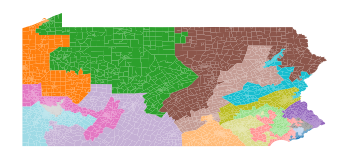

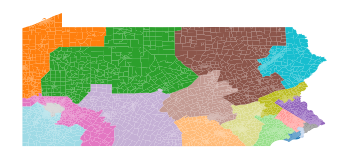

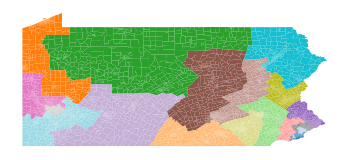

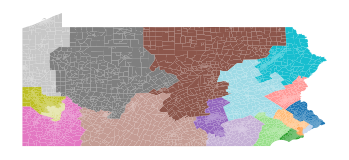

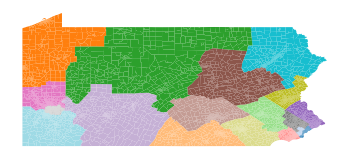

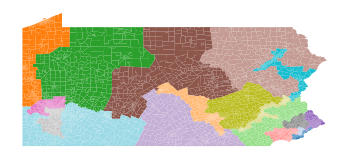

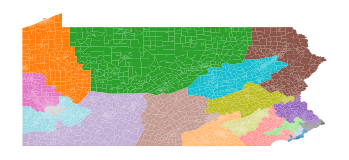

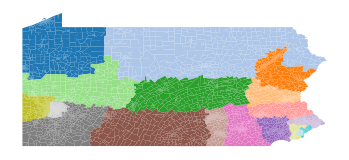

In [80]:
# makes all human made partitions

for n in graph.nodes():
    graph.nodes[n]['538CPCT__1'] = int(graph.nodes[n]['538CPCT__1'])
    graph.nodes[n]['538DEM_PL'] = int(graph.nodes[n]['538DEM_PL'])
    graph.nodes[n]['538GOP_PL'] = int(graph.nodes[n]['538GOP_PL'])
    graph.nodes[n]['8THGRADE_1'] = int(graph.nodes[n]['8THGRADE_1'])
    
partition_2011 = Partition(graph, "2011_PLA_1", updaters1)
partition_GOV = Partition(graph, "GOV", updaters1)
partition_TS = Partition(graph, "TS", updaters1)
partition_REMEDIAL = Partition(graph, "REMEDIAL_P", updaters1)
partition_CPCT = Partition(graph, "538CPCT__1", updaters1)
partition_DEM = Partition(graph, "538DEM_PL", updaters1)
partition_GOP = Partition(graph, "538GOP_PL", updaters1)
partition_8th = Partition(graph, "8THGRADE_1", updaters1)

partitions = [partition_2011, partition_GOV, partition_TS,
                  partition_REMEDIAL, partition_CPCT, partition_DEM,
                  partition_GOP, partition_8th]

labels = ["2011","GOV","Proposed_Republican","Remdial","CPCT","DEM","GOP","8TH"]

for i in range(8):
    part = partitions[i]
    label = labels[i]
    df["min_plot"] = df["GEOID10"].map(dict(part.assignment))
    df.plot(column="min_plot", cmap="tab20")
    plt.axis('off')
    plt.savefig(newdir + label+"_map.png")
    plt.show()


In [11]:
# maps each county FIPS code to their county name

county_labels={'001':'Adams', '003':'Allegheny' , '005':'Armstrong' , '007':'Beaver' , '009':'Bedford' , 
                  '011':'Berks' , '013':'Blair' , '015':'Bradford' , '017':'Bucks' , '019':'Butler' , 
                  '021':'Cambrida' , '023':'Cameron' , '025':'Carbon' , '027':'Centre' , '029':'Chester' ,
                  '031':'Clarion' , '033':'Clearfield' , '035':'Clinton' , '037':'Columbia' , '039':'Crawford' , 
                  '041':'Cumberland' , '043':'Dauphin' , '045':'Delaware' , '047':'Elk' , '049':'Erie' , '051':'Fayette' , 
                  '053':'Forest' , '055':'Franklin' , '057':'Fulton' , '059':'Greene' , '061':'Huntingdon' , 
                  '063':'Indiana' , '065':'Jefferson' , '067':'Juniata' , '069':'Lackawanna' , '071':'Lancaster' ,
                  '073':'Lawrence' , '075':'Lebanon' , '077':'Lehigh' , '079':'Luzerne' , '081':'Lycoming' , 
                  '083':'McKean' , '085':'Mercer' , '087':'Mifflin' , '089':'Monroe' , '091':'Montgomery' ,
                  '093':'Montour' , '095':'Northampton' , '097':'Northumberland' , '099':'Perry' , '101':'Philadelphia' ,
                  '103':'Pike' , '105':'Potter' , '107':'Schuylkill' , '109':'Snyder' , '111':'Somerset' ,
                  '113':'Sullivan' , '115':'Susquehanna' , '117':'Tioga' , '119':'Union' , '121':'Venango' ,
                  '123':'Warren' , '125':'Washington' , '127':'Wayne' , '129':'Westmoreland' , '131':'Wyoming' , 
                  '133':'York'
               }

{'001': 'Adams', '003': 'Allegheny', '005': 'Armstrong', '007': 'Beaver', '009': 'Bedford', '011': 'Berks', '013': 'Blair', '015': 'Bradford', '017': 'Bucks', '019': 'Butler', '021': 'Cambrida', '023': 'Cameron', '025': 'Carbon', '027': 'Centre', '029': 'Chester', '031': 'Clarion', '033': 'Clearfield', '035': 'Clinton', '037': 'Columbia', '039': 'Crawford', '041': 'Cumberland', '043': 'Dauphin', '045': 'Delaware', '047': 'Elk', '049': 'Erie', '051': 'Fayette', '053': 'Forest', '055': 'Franklin', '057': 'Fulton', '059': 'Greene', '061': 'Huntingdon', '063': 'Indiana', '065': 'Jefferson', '067': 'Juniata', '069': 'Lackawanna', '071': 'Lancaster', '073': 'Lawrence', '075': 'Lebanon', '077': 'Lehigh', '079': 'Luzerne', '081': 'Lycoming', '083': 'McKean', '085': 'Mercer', '087': 'Mifflin', '089': 'Monroe', '091': 'Montgomery', '093': 'Montour', '095': 'Northampton', '097': 'Northumberland', '099': 'Perry', '101': 'Philadelphia', '103': 'Pike', '105': 'Potter', '107': 'Schuylkill', '109': 'S

In [12]:
#print(graph.nodes())
starting_partition = GeographicPartition(
    graph,
    assignment="GOV",
    updaters=updaters1
)

In [13]:
def county_splits_dict(partition):
    ''' returns a dictionary with keys as district numbers and values Counter() dictionaries
        these counter dictionaries have pairs COUNTY_ID : NUM which counts the number of VTDS
        in the county in the district
        
    '''
    
    county_splits = {k:[] for k in counties}
    county_splits = {  k:[countydict[v] for v in d] for k,d in partition.assignment.parts.items()   }
    county_splits = {k: Counter(v) for k,v in county_splits.items()}
    return county_splits

In [85]:
# calculats number of splits

def num_of_split_counties(partition):
    count_splits_dict = county_splits_dict(partition)
    count = 0
    
    for county in counties:
        current = 0
        add_sum = 0
        for i in range(len(count_splits_dict)):
            if county in count_splits_dict[i+1] and current == 0:
                current = 1
            elif county in count_splits_dict[i+1] and current == 1:
                add_sum = 1
        count += add_sum
    return count

14


In [15]:
#maps county to all districts that touch it

def district_splits_dict(county_splits):
    district_splits = {k:[] for k in counties}
    
    for county in counties:
        districts = {}
        for district in county_splits.keys():
            if county in county_splits[district].keys():
                district_splits[county].append(district)
    return district_splits            
            

In [17]:
# calculates population of each county

def pops_per_county(county_splits,rev):
    pops = {}
    
    for county in rev.keys():
        pop = 0
        for vtd in rev[county]:
            pop += graph.nodes[vtd]["TOT_POP"]
        pops[county] = pop
    return pops

In [18]:
# calculates the population of each district.

def pops_per_district(partition):
    dictionary = dict(partition.assignment)
    pops = {}
    
    for i in range(num_districts):
        for vtd in dictionary.keys():
            if i+1 in pops and dictionary[vtd] == i + 1:
                pops[i+1] += graph.nodes[vtd]["TOT_POP"]
            elif dictionary[vtd] == i+1:
                pops[i+1] = graph.nodes[vtd]["TOT_POP"]
    return pops

In [19]:
def VTDs_to_Counties(partition):
    '''
    Consumes a partition which is converted into a dictionary with keys as districts
    and values as a list of VTDs that are in that district.
    Returns a dictionary with keys as districts and values
    as dictionaries of county-population key-value pairs. This represents the population
    of each county that is in each district.
    '''
    district_dict = dict(partition.parts)
    new_district_dict = dict(partition.parts)
    for district in district_dict.keys():
        vtds = district_dict[district]
        county_pop = {k:0 for k in counties}
        for vtd in vtds:
            county_pop[countydict[vtd]] += graph.nodes[vtd][pop_col]
        new_district_dict[district] = county_pop
    return new_district_dict

In [22]:
# caculates the number of pieces in a partition

def num_of_pieces(partition):
    county_pieces = dict_counties_to_splits(partition)
    num = 0
    for county in county_pieces.keys():
        num += county_pieces[county]
    return num

In [23]:
# maps the counties to how many pieces they're divided into 

def dict_counties_to_splits(partition):
    county_dict = county_splits_dict(partition)
    new_dict = {x:0 for x in counties}
    for county in counties:
        for district in county_dict.keys():
            counter = county_dict[district]
            if county in counter.keys():
                new_dict[county] += 1
    return new_dict
    

In [25]:
###################################################

# returns a dictionary that maps a county to a list of VTDs that are in the counth

def reverse_countydict():
    rev = {k:[] for k in counties}
    for county in counties:
        for vtd in countydict.keys():
            if countydict[vtd] == county:
                rev[county].append(vtd)
    return rev

In [26]:
####################################################

# calculates the population of a given county

def county_pop(rev, county_j):
    pop = 0
    for vtd in rev[county_j]:
        pop += graph.nodes[vtd]["TOT_POP"]
    return pop

In [27]:
###################################################

# calculates population of given district

def district_pop(part, district_i):
    pop = 0
    for vtd in dict(part.parts)[district_i]:
        pop += graph.nodes[vtd]["TOT_POP"]
    return pop

In [28]:
#############################################

#calculates population of intersection of given district and county

def intersection_pop(part, county_vtds, county_j, district_i):
    intersection = [vtd for vtd in county_vtds[county_j] if vtd in dict(part.parts)[district_i]]
    
    pop = 0
    for vtd in intersection:
        pop += graph.nodes[vtd]["TOT_POP"]
    return pop

In [29]:
###########################################

# calculates Shannon entropy
# rev is dictionary mapping county to list of VTDs in county

def relative_entropy(partition, rev=reverse_countydict() ): 
    entropy = 0
    for county_j in counties:
        inner_sum = 0
        cpop = county_pop(rev,county_j)
        q = cpop / totpop
        for district_i in range(num_districts):
            p = intersection_pop(partition,rev,county_j,district_i+1) / cpop 
            if p != 0:
                inner_sum += p * math.log(1/p,2)
        entropy += q * inner_sum
    return entropy

In [30]:
#county_vtds = county_splits_dict(starting_partition)
#print(power_entropy(county_splits,vtds,total,0.5))
rev = reverse_countydict() 

#print(Shannon_entropy(starting_partition,rev))

In [31]:
d = county_splits_dict(starting_partition)
sum( [ len([ dd for dd  in [dict(v) for v in d.values()] if k in dd.keys()]) > 1 for k in counties] )
#print(our_split_score_1(starting_partition))
#print(our_split_score_2(starting_partition))
#print(too_many_pieces(starting_partition))
#print(other_too_many_pieces(starting_partition))
#print(district_splits_dict(county_splits))


19

In [32]:
#acceptance functions designed to minimize their given score

def decrease_splits(partition, bad_mobility_prob = 0.2):
    if partition.parent is None:
        return True
    
    curr_splits = num_of_split_counties(partition)
    prev_splits = num_of_split_counties(partition.parent)
        
    if curr_splits <= prev_splits: 
        return True
    else:
        return random.random() < bad_mobility_prob
    
def decrease_pieces(partition, bad_mobility_prob = 0.1):
    if partition.parent is None:
        return True
    
    curr_splits = num_of_pieces(partition)
    prev_splits = num_of_pieces(partition.parent)
        
    if curr_splits <= prev_splits: 
        return True
    else:
        return random.random() < bad_mobility_prob
    
def decrease_entropy(partition, bad_mobility_prob = 0.05):
    if partition.parent is None:
        return True
    
    curr_entropy = relative_entropy(partition)
    prev_entropy= relative_entropy(partition.parent)
        
    if curr_entropy <= prev_entropy: 
        return True
    else:
        return random.random() < bad_mobility_prob

In [33]:
proposal = partial(
        recom, pop_col="TOT_POP", pop_target=totpop/num_districts, epsilon=0.02, node_repeats=1
    )

compactness_bound = constraints.UpperBound(
        lambda p: len(p["cut_edges"]), 2 * len(starting_partition["cut_edges"])
    )

popbound=constraints.within_percent_of_ideal_population(starting_partition, 0.05)

chain = MarkovChain(
        proposal,
        constraints=[
            constraints.within_percent_of_ideal_population(starting_partition, 0.05),compactness_bound
          #constraints.single_flip_contiguous#no_more_discontiguous
        ],
        accept=accept.always_accept,
        initial_state=starting_partition,
        total_steps=0
    )

In [34]:
# Markov Chain in short bursts

def short_burst_run(initial_partition, num_bursts, num_steps, accept_function, score_function):
    min_partition = initial_partition
    min_score = 10000000 # bhushan come back here later...
    minindex = 0
    
    scores = []
    splitsM = []
    piecesM = []
    entropyM = []
    k=0
    
    for i in range(num_bursts):
        chain = MarkovChain(proposal, 
                          Validator([popbound]), 
                          accept=accept_function,
                          initial_state=min_partition, 
                          total_steps=num_steps)

        t=0
        for partition in chain:
            splitsM.append(num_of_split_counties(partition))
            piecesM.append(num_of_pieces(partition))
            entropyM.append(relative_entropy(partition))
            current_score = score_function(partition)
            if current_score < min_score: # > or >= has implications, not sure which is best...
                min_partition = partition
                min_score = current_score
                minindex = k
            
            scores.append(current_score)
            # TODO: nasty code that needs to be rewritten
            seen_partition = initial_partition
            current_partition = partition
            seen_list = seen_partition.parts.values()
            seen_list = [sorted(list(unit)) for unit in seen_list]
            seen_list = sorted(seen_list)
        
            curr_list = current_partition.parts.values()
            curr_list = [sorted(list(unit)) for unit in curr_list]
            curr_list = sorted(curr_list)
        
            if seen_list == curr_list:
                print("same partition")
            t+=1
            k+=1
            if t%10 ==0:
                print("chain no. ",t)
            
        if i % 1 == 0:
            print("Burst no. ", i)
                
    return scores,splitsM,piecesM,entropyM,minindex,min_partition

Plan     Entropy     Splits     Pieces
2011: 0.8676076673152497 29 108
GOV: 0.5787684006656545 19 89
Proposed_Republican: 0.6010406768281862 16 87
Remdial: 0.47440698838805545 14 85
CPCT: 0.4822761911728323 13 84
DEM: 0.9204245390077089 31 114
GOP: 0.817224636503494 22 99
8TH: 0.8332692700716872 42 129


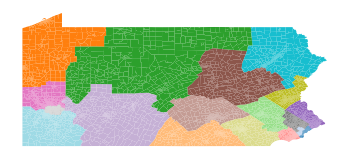

In [35]:
# compares the scores for the human-made plans

entropy = []
splits = []
pieces = []

for part in partitions:
    entropy.append(relative_entropy(part,rev))
    splits.append(num_of_split_counties(part))
    pieces.append(num_of_pieces(part))

print("Plan     Entropy     Splits     Pieces")
for i in range(8):
    print(labels[i]+': ',end='')
    print(entropy[i],end=' ')
    print(splits[i],end = ' ')
    print(pieces[i])

#markov_splits = short_burst_run(partition_2011,10,3,decrease_splits,num_of_split_counties)
#print(markov_splits)

#markov_pieces = short_burst_run(partition_2011,10,3,accept.always_accept,num_of_pieces)
#print(markov_pieces)

df["min_plot"] = df["GEOID10"].map(dict(partition_CPCT.assignment))
df.plot(column="min_plot", cmap="tab20")
plt.axis('off')
plt.show()

In [88]:
# short bursts run that is biased towards low entropy scores

bursts0 = 5000
steps0 = 3

markov_entropy0,markov_splits0,markov_pieces0,other_entropy0,minind0,min_part0= short_burst_run(partition_REMEDIAL,bursts0,steps0,decrease_entropy,relative_entropy)

same partition
same partition
same partition
Burst no.  0
same partition
same partition
same partition
Burst no.  1
same partition
same partition
same partition
Burst no.  2
same partition
same partition
same partition
Burst no.  3
same partition
same partition
same partition
Burst no.  4
same partition
same partition
same partition
Burst no.  5
same partition
Burst no.  6
Burst no.  7
Burst no.  8
Burst no.  9
Burst no.  10
Burst no.  11
Burst no.  12
Burst no.  13
Burst no.  14
Burst no.  15
Burst no.  16
Burst no.  17
Burst no.  18
Burst no.  19
Burst no.  20
Burst no.  21
Burst no.  22
Burst no.  23
Burst no.  24
Burst no.  25
Burst no.  26
Burst no.  27
Burst no.  28
Burst no.  29
Burst no.  30
Burst no.  31
Burst no.  32
Burst no.  33
Burst no.  34
Burst no.  35
Burst no.  36
Burst no.  37
Burst no.  38
Burst no.  39
Burst no.  40
Burst no.  41
Burst no.  42
Burst no.  43
Burst no.  44
Burst no.  45
Burst no.  46
Burst no.  47
Burst no.  48
Burst no.  49
Burst no.  50
Burst no.  

Burst no.  535
Burst no.  536
Burst no.  537
Burst no.  538
Burst no.  539
Burst no.  540
Burst no.  541
Burst no.  542
Burst no.  543
Burst no.  544
Burst no.  545
Burst no.  546
Burst no.  547
Burst no.  548
Burst no.  549
Burst no.  550
Burst no.  551
Burst no.  552
Burst no.  553
Burst no.  554
Burst no.  555
Burst no.  556
Burst no.  557
Burst no.  558
Burst no.  559
Burst no.  560
Burst no.  561
Burst no.  562
Burst no.  563
Burst no.  564
Burst no.  565
Burst no.  566
Burst no.  567
Burst no.  568
Burst no.  569
Burst no.  570
Burst no.  571
Burst no.  572
Burst no.  573
Burst no.  574
Burst no.  575
Burst no.  576
Burst no.  577
Burst no.  578
Burst no.  579
Burst no.  580
Burst no.  581
Burst no.  582
Burst no.  583
Burst no.  584
Burst no.  585
Burst no.  586
Burst no.  587
Burst no.  588
Burst no.  589
Burst no.  590
Burst no.  591
Burst no.  592
Burst no.  593
Burst no.  594
Burst no.  595
Burst no.  596
Burst no.  597
Burst no.  598
Burst no.  599
Burst no.  600
Burst no. 

Burst no.  1077
Burst no.  1078
Burst no.  1079
Burst no.  1080
Burst no.  1081
Burst no.  1082
Burst no.  1083
Burst no.  1084
Burst no.  1085
Burst no.  1086
Burst no.  1087
Burst no.  1088
Burst no.  1089
Burst no.  1090
Burst no.  1091
Burst no.  1092
Burst no.  1093
Burst no.  1094
Burst no.  1095
Burst no.  1096
Burst no.  1097
Burst no.  1098
Burst no.  1099
Burst no.  1100
Burst no.  1101
Burst no.  1102
Burst no.  1103
Burst no.  1104
Burst no.  1105
Burst no.  1106
Burst no.  1107
Burst no.  1108
Burst no.  1109
Burst no.  1110
Burst no.  1111
Burst no.  1112
Burst no.  1113
Burst no.  1114
Burst no.  1115
Burst no.  1116
Burst no.  1117
Burst no.  1118
Burst no.  1119
Burst no.  1120
Burst no.  1121
Burst no.  1122
Burst no.  1123
Burst no.  1124
Burst no.  1125
Burst no.  1126
Burst no.  1127
Burst no.  1128
Burst no.  1129
Burst no.  1130
Burst no.  1131
Burst no.  1132
Burst no.  1133
Burst no.  1134
Burst no.  1135
Burst no.  1136
Burst no.  1137
Burst no.  1138
Burst no

Burst no.  1590
Burst no.  1591
Burst no.  1592
Burst no.  1593
Burst no.  1594
Burst no.  1595
Burst no.  1596
Burst no.  1597
Burst no.  1598
Burst no.  1599
Burst no.  1600
Burst no.  1601
Burst no.  1602
Burst no.  1603
Burst no.  1604
Burst no.  1605
Burst no.  1606
Burst no.  1607
Burst no.  1608
Burst no.  1609
Burst no.  1610
Burst no.  1611
Burst no.  1612
Burst no.  1613
Burst no.  1614
Burst no.  1615
Burst no.  1616
Burst no.  1617
Burst no.  1618
Burst no.  1619
Burst no.  1620
Burst no.  1621
Burst no.  1622
Burst no.  1623
Burst no.  1624
Burst no.  1625
Burst no.  1626
Burst no.  1627
Burst no.  1628
Burst no.  1629
Burst no.  1630
Burst no.  1631
Burst no.  1632
Burst no.  1633
Burst no.  1634
Burst no.  1635
Burst no.  1636
Burst no.  1637
Burst no.  1638
Burst no.  1639
Burst no.  1640
Burst no.  1641
Burst no.  1642
Burst no.  1643
Burst no.  1644
Burst no.  1645
Burst no.  1646
Burst no.  1647
Burst no.  1648
Burst no.  1649
Burst no.  1650
Burst no.  1651
Burst no

Burst no.  2103
Burst no.  2104
Burst no.  2105
Burst no.  2106
Burst no.  2107
Burst no.  2108
Burst no.  2109
Burst no.  2110
Burst no.  2111
Burst no.  2112
Burst no.  2113
Burst no.  2114
Burst no.  2115
Burst no.  2116
Burst no.  2117
Burst no.  2118
Burst no.  2119
Burst no.  2120
Burst no.  2121
Burst no.  2122
Burst no.  2123
Burst no.  2124
Burst no.  2125
Burst no.  2126
Burst no.  2127
Burst no.  2128
Burst no.  2129
Burst no.  2130
Burst no.  2131
Burst no.  2132
Burst no.  2133
Burst no.  2134
Burst no.  2135
Burst no.  2136
Burst no.  2137
Burst no.  2138
Burst no.  2139
Burst no.  2140
Burst no.  2141
Burst no.  2142
Burst no.  2143
Burst no.  2144
Burst no.  2145
Burst no.  2146
Burst no.  2147
Burst no.  2148
Burst no.  2149
Burst no.  2150
Burst no.  2151
Burst no.  2152
Burst no.  2153
Burst no.  2154
Burst no.  2155
Burst no.  2156
Burst no.  2157
Burst no.  2158
Burst no.  2159
Burst no.  2160
Burst no.  2161
Burst no.  2162
Burst no.  2163
Burst no.  2164
Burst no

Burst no.  2616
Burst no.  2617
Burst no.  2618
Burst no.  2619
Burst no.  2620
Burst no.  2621
Burst no.  2622
Burst no.  2623
Burst no.  2624
Burst no.  2625
Burst no.  2626
Burst no.  2627
Burst no.  2628
Burst no.  2629
Burst no.  2630
Burst no.  2631
Burst no.  2632
Burst no.  2633
Burst no.  2634
Burst no.  2635
Burst no.  2636
Burst no.  2637
Burst no.  2638
Burst no.  2639
Burst no.  2640
Burst no.  2641
Burst no.  2642
Burst no.  2643
Burst no.  2644
Burst no.  2645
Burst no.  2646
Burst no.  2647
Burst no.  2648
Burst no.  2649
Burst no.  2650
Burst no.  2651
Burst no.  2652
Burst no.  2653
Burst no.  2654
Burst no.  2655
Burst no.  2656
Burst no.  2657
Burst no.  2658
Burst no.  2659
Burst no.  2660
Burst no.  2661
Burst no.  2662
Burst no.  2663
Burst no.  2664
Burst no.  2665
Burst no.  2666
Burst no.  2667
Burst no.  2668
Burst no.  2669
Burst no.  2670
Burst no.  2671
Burst no.  2672
Burst no.  2673
Burst no.  2674
Burst no.  2675
Burst no.  2676
Burst no.  2677
Burst no

Burst no.  3129
Burst no.  3130
Burst no.  3131
Burst no.  3132
Burst no.  3133
Burst no.  3134
Burst no.  3135
Burst no.  3136
Burst no.  3137
Burst no.  3138
Burst no.  3139
Burst no.  3140
Burst no.  3141
Burst no.  3142
Burst no.  3143
Burst no.  3144
Burst no.  3145
Burst no.  3146
Burst no.  3147
Burst no.  3148
Burst no.  3149
Burst no.  3150
Burst no.  3151
Burst no.  3152
Burst no.  3153
Burst no.  3154
Burst no.  3155
Burst no.  3156
Burst no.  3157
Burst no.  3158
Burst no.  3159
Burst no.  3160
Burst no.  3161
Burst no.  3162
Burst no.  3163
Burst no.  3164
Burst no.  3165
Burst no.  3166
Burst no.  3167
Burst no.  3168
Burst no.  3169
Burst no.  3170
Burst no.  3171
Burst no.  3172
Burst no.  3173
Burst no.  3174
Burst no.  3175
Burst no.  3176
Burst no.  3177
Burst no.  3178
Burst no.  3179
Burst no.  3180
Burst no.  3181
Burst no.  3182
Burst no.  3183
Burst no.  3184
Burst no.  3185
Burst no.  3186
Burst no.  3187
Burst no.  3188
Burst no.  3189
Burst no.  3190
Burst no

Burst no.  3642
Burst no.  3643
Burst no.  3644
Burst no.  3645
Burst no.  3646
Burst no.  3647
Burst no.  3648
Burst no.  3649
Burst no.  3650
Burst no.  3651
Burst no.  3652
Burst no.  3653
Burst no.  3654
Burst no.  3655
Burst no.  3656
Burst no.  3657
Burst no.  3658
Burst no.  3659
Burst no.  3660
Burst no.  3661
Burst no.  3662
Burst no.  3663
Burst no.  3664
Burst no.  3665
Burst no.  3666
Burst no.  3667
Burst no.  3668
Burst no.  3669
Burst no.  3670
Burst no.  3671
Burst no.  3672
Burst no.  3673
Burst no.  3674
Burst no.  3675
Burst no.  3676
Burst no.  3677
Burst no.  3678
Burst no.  3679
Burst no.  3680
Burst no.  3681
Burst no.  3682
Burst no.  3683
Burst no.  3684
Burst no.  3685
Burst no.  3686
Burst no.  3687
Burst no.  3688
Burst no.  3689
Burst no.  3690
Burst no.  3691
Burst no.  3692
Burst no.  3693
Burst no.  3694
Burst no.  3695
Burst no.  3696
Burst no.  3697
Burst no.  3698
Burst no.  3699
Burst no.  3700
Burst no.  3701
Burst no.  3702
Burst no.  3703
Burst no

Burst no.  4155
Burst no.  4156
Burst no.  4157
Burst no.  4158
Burst no.  4159
Burst no.  4160
Burst no.  4161
Burst no.  4162
Burst no.  4163
Burst no.  4164
Burst no.  4165
Burst no.  4166
Burst no.  4167
Burst no.  4168
Burst no.  4169
Burst no.  4170
Burst no.  4171
Burst no.  4172
Burst no.  4173
Burst no.  4174
Burst no.  4175
Burst no.  4176
Burst no.  4177
Burst no.  4178
Burst no.  4179
Burst no.  4180
Burst no.  4181
Burst no.  4182
Burst no.  4183
Burst no.  4184
Burst no.  4185
Burst no.  4186
Burst no.  4187
Burst no.  4188
Burst no.  4189
Burst no.  4190
Burst no.  4191
Burst no.  4192
Burst no.  4193
Burst no.  4194
Burst no.  4195
Burst no.  4196
Burst no.  4197
Burst no.  4198
Burst no.  4199
Burst no.  4200
Burst no.  4201
Burst no.  4202
Burst no.  4203
Burst no.  4204
Burst no.  4205
Burst no.  4206
Burst no.  4207
Burst no.  4208
Burst no.  4209
Burst no.  4210
Burst no.  4211
Burst no.  4212
Burst no.  4213
Burst no.  4214
Burst no.  4215
Burst no.  4216
Burst no

Burst no.  4668
Burst no.  4669
Burst no.  4670
Burst no.  4671
Burst no.  4672
Burst no.  4673
Burst no.  4674
Burst no.  4675
Burst no.  4676
Burst no.  4677
Burst no.  4678
Burst no.  4679
Burst no.  4680
Burst no.  4681
Burst no.  4682
Burst no.  4683
Burst no.  4684
Burst no.  4685
Burst no.  4686
Burst no.  4687
Burst no.  4688
Burst no.  4689
Burst no.  4690
Burst no.  4691
Burst no.  4692
Burst no.  4693
Burst no.  4694
Burst no.  4695
Burst no.  4696
Burst no.  4697
Burst no.  4698
Burst no.  4699
Burst no.  4700
Burst no.  4701
Burst no.  4702
Burst no.  4703
Burst no.  4704
Burst no.  4705
Burst no.  4706
Burst no.  4707
Burst no.  4708
Burst no.  4709
Burst no.  4710
Burst no.  4711
Burst no.  4712
Burst no.  4713
Burst no.  4714
Burst no.  4715
Burst no.  4716
Burst no.  4717
Burst no.  4718
Burst no.  4719
Burst no.  4720
Burst no.  4721
Burst no.  4722
Burst no.  4723
Burst no.  4724
Burst no.  4725
Burst no.  4726
Burst no.  4727
Burst no.  4728
Burst no.  4729
Burst no

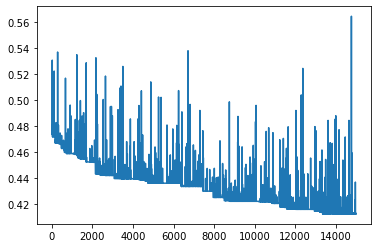

0.41248823281513225


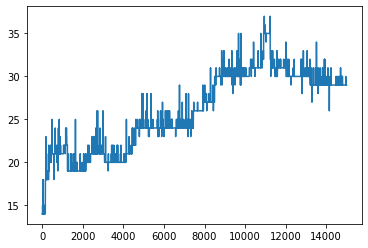

30


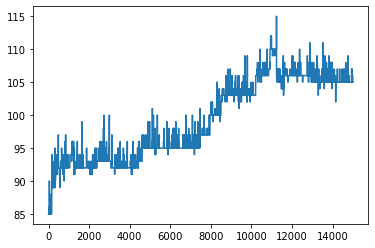

106


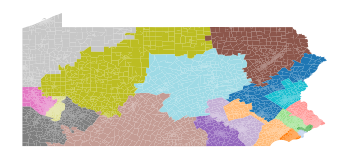

In [91]:
#plots line plots of the scores found in the previous short bursts run

plt.plot(range(bursts0*steps0),markov_entropy0)
plt.show()

print(min(markov_entropy0))

plt.plot(range(bursts0*steps0),markov_splits0)
plt.show()

print(markov_splits[minind0])

plt.plot(range(bursts0*steps0),markov_pieces0)
plt.show()

print(markov_pieces[minind0])

df["min_plot"] = df["GEOID10"].map(dict(min_part0.assignment))
df.plot(column="min_plot", cmap="tab20")
plt.axis('off')
plt.savefig(newdir + "Minimized_entropy_map.png")
plt.show()